<a href="https://colab.research.google.com/github/netgvarun2021/Blackbox/blob/main/KaggleFeedbackPrize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers seqeval[gpu]

     |████████████████████████████████| 3.4 MB 8.7 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
     |████████████████████████████████| 895 kB 58.5 MB/s 
     |████████████████████████████████| 596 kB 67.6 MB/s 
     |████████████████████████████████| 61 kB 581 kB/s 
     |████████████████████████████████| 3.3 MB 60.2 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=9704391f09a9ece669ead099a7b82793ebcb808c7b5c544e55ccf8d8f1f9138c
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertConfig, BertForTokenClassification
import os
import spacy

In [3]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


 # "Barack Obama was born in Hawaï", then the corresponding tags would be 
 [B-PERS, I-PERS, O, O, O, B-GEO].

 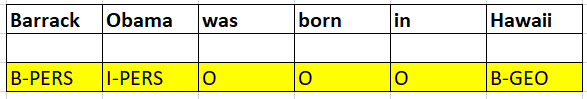

 B-PERS means that the word "Barack" is the beginning of a person, I-PERS means that the word "Obama" is inside a person, "O" means that the word "was" is outside a named entity, and so on.

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
train_dir = '/content/gdrive/MyDrive/KaggleArgumentEssay/'
train_ds = os.path.join(train_dir, 'train.csv')

In [6]:
df =  pd.read_csv(train_ds) 

In [7]:
df.head()

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring
0,423A1CA112E2,1.622628e+12,8.0,229.0,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
1,423A1CA112E2,1.622628e+12,230.0,312.0,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
2,423A1CA112E2,1.622628e+12,313.0,401.0,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
3,423A1CA112E2,1.622628e+12,402.0,758.0,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...
4,423A1CA112E2,1.622628e+12,759.0,886.0,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...


So if you want to train a deep learning model for NER, it requires that you have your data in this IOB format (or similar formats such as BILOU). There exist many annotation tools which let you create these kind of annotations automatically (such as Spacy's Prodigy, Tagtog or Doccano). You can also use Spacy's biluo_tags_from_offsets function to convert annotations at the character level to IOB format.

In [8]:
!pip install spacy

In [9]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9 MB 1.4 MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-py3-none-any.whl size=829180942 sha256=ab584ff9bd15fa9b7f0bf6528f620cc799f352d46b59f3bac271a015378cdcca
  Stored in directory: /tmp/pip-ephem-wheel-cache-cwlslhuu/wheels/11/95/ba/2c36cc368c0bd339b44a791c2c1881a1fb714b78c29a4cb8f5
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [2]:
import spacy
nlp = spacy.load('en_core_web_lg')


In [31]:
def get_ner_tags(text,d_type):
  ner_list = []
  doc=nlp(text)
  for token in doc:
    ner_list.append(token.ent_iob_+'-'+d_type)
  return ','.join([str(elem) for elem in ner_list])

In [29]:
df['Tags']  = df.apply(lambda x: get_ner_tags(x['discourse_text'], x['discourse_type']), axis=1)


In [30]:
df.head()

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring,Tags
0,423A1CA112E2,1.622628e+12,8.0,229.0,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...,O-Lead O-Lead B-Lead O-Lead O-Lead O-Lead O-Le...
1,423A1CA112E2,1.622628e+12,230.0,312.0,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59,O-Position O-Position O-Position O-Position O-...
2,423A1CA112E2,1.622628e+12,313.0,401.0,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75,O-Evidence O-Evidence O-Evidence O-Evidence B-...
3,423A1CA112E2,1.622628e+12,402.0,758.0,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...,O-Evidence O-Evidence O-Evidence O-Evidence O-...
4,423A1CA112E2,1.622628e+12,759.0,886.0,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...,O-Claim O-Claim O-Claim O-Claim O-Claim O-Clai...


In [44]:
df.iloc[400].discourse_text

'According to research cell phones are the leading factors that cause accidents today. But, despite the danger, people still use cell phones because they want to always stay in touch with other people. '

In [37]:
#df.iloc[40].Tags
print(df['Tags'].values[0])

O-Lead O-Lead B-Lead O-Lead O-Lead O-Lead O-Lead O-Lead O-Lead O-Lead O-Lead O-Lead O-Lead O-Lead O-Lead B-Lead I-Lead I-Lead I-Lead O-Lead O-Lead O-Lead O-Lead O-Lead O-Lead O-Lead O-Lead O-Lead O-Lead O-Lead O-Lead O-Lead O-Lead O-Lead O-Lead B-Lead O-Lead O-Lead O-Lead O-Lead O-Lead O-Lead O-Lead O-Lead O-Lead O-Lead O-Lead


In [51]:
doc=nlp("Barack Obama was born in Hawaï")
for token in doc:
  print(token.ent_iob_+'-'+token.ent_type_)

B-PERSON
I-PERSON
O-
O-
O-
B-PERSON


In [10]:
def make_tag_lookup_table():
    iob_labels = ["B", "I"]
    ner_labels = ["PER", "ORG", "LOC", "MISC"]
    all_labels = [(label1, label2) for label2 in ner_labels for label1 in iob_labels]
    all_labels = ["-".join([a, b]) for a, b in all_labels]
    all_labels = ["[PAD]", "O"] + all_labels
    return dict(zip(range(0, len(all_labels) + 1), all_labels))


mapping = make_tag_lookup_table()
print(mapping)

{0: '[PAD]', 1: 'O', 2: 'B-PER', 3: 'I-PER', 4: 'B-ORG', 5: 'I-ORG', 6: 'B-LOC', 7: 'I-LOC', 8: 'B-MISC', 9: 'I-MISC'}


In [40]:
def generate_tags(labels: 'list[str]', scheme="IOB"): # '[list[str], dict[str, int]]':
    """
    params
    ------
    df: 
        The dataframe specific for a certain text
    labels: 
        A list of text labels (e.g. ["PER", "LOC"])
    scheme:
        Which scheme to use. Has to be one of:
            - "IO"
            - "IOB", "BIO"
            - "BILOU"
            - "BIOES"

    returns
    -------
    tags: 
        List of tags created from the labels (e.g. ["O", "I-PER", "B-PER", "I-LOC", "B-LOC"]
        if you use scheme="IOB")
    tag_to_num: 
        A dictionary mapping a tag to a number in tagged_chars
    """
    labels = set(labels)
    
    tags = ['O']
    scheme = scheme.upper().replace("O", "")

    for label in labels:
        for prefix in scheme:
            tags.append(f"{prefix}-{label}")

    tag_to_num = {tag: i for i, tag in enumerate(tags)}

    return tags, tag_to_num

def create_target(
    text: str, labels: 'list[str]', start: 'list[str]', end: 'list[str]', offset_mapping: 'list[tuple]', 
    tag_to_num: 'dict[str, int]', scheme: str = "IOB"
) -> 'list[list[int]]':
    """
    This function uses the offsets from a tokenizer and the labeled characters to create the NER target tags 
    in the Huggingface transformers format. It takes into account the scheme you are using (by default IOB).
    
    params
    ------
    text: 
        The text we want to tag
    labels:
        A list of text labels (e.g. ["PER", "LOC"])
    start: 
        List of start index (character-level) for the corresponding label
    end: 
        List of end index (character-level) for the corresponding label
    offset_mapping: 
        The offsets obtained from huggingface tokenizers when offsets_mapping=True 
    labeled_chars: 
        the labeled characters from apply_labels
    tag_to_num: 
        A dictionary mapping a tag to a number in tagged_chars
    scheme:
        Which scheme to use. Has to be one of:
            - "IO"
            - "IOB", "BIO",
            - "BILOU"
            - "BIOES"
    
    returns
    -------
    target
        list of list of target tokens matching the length of the offset_mapping
    """
    scheme = scheme.upper()
    start = list(start)
    end = list(end)
    labels = list(labels)
    
    tag_lst = list(tag_to_num)
    
    i = 0
    j = 0
    iend = len(start)
    jend = len(offset_mapping)

    target = [tag_to_num['O']] * len(offset_mapping)

    is_first = True

    if "L" in scheme:
        end_char = "L"
    elif "E" in scheme:
        end_char = "E"
    else:
        end_char = "I"

    if "U" in scheme:
        unit_char = "U"
    elif "S" in scheme:
        unit_char = "S"
    elif "B" in scheme:
        unit_char = "B"
    else:
        unit_char = "I"

    while i < iend and j < jend:
        s = int(start[i])
        e = int(end[i])
        label = labels[i]
        
        s_off, e_off = offset_mapping[j]
        
        # [PAD], [SEP] and [CLS] will have (0, 0) 
        if is_first and s_off >= s and e_off >= e:
            tag = f"{unit_char}-{label}"
            target[j] = tag_to_num[tag]
            
            j += 1
            i += 1
        
        elif j != (jend - 1) and offset_mapping[j+1][0] >= e:
            is_first = True
            tag = f"{end_char}-{label}"
            target[j] = tag_to_num[tag]
            i += 1
        
        elif e_off - s_off == 0:
            j+=1
        
             
        elif j == (jend - 1):
            is_first = True
            tag = f"{end_char}-{label}"
            target[j] = tag_to_num[tag]
            i += 1
            j += 1
        

        elif s <= s_off < e:
            if is_first and "B" in scheme:
                is_first = False
                tag = f"B-{label}"
            else:
                tag = f"I-{label}"    
            
            
            target[j] = tag_to_num[tag]
            
            j += 1
        elif s_off < s:
            j += 1
            is_first = True

    
    return target

if __name__ == "__main__":
    # "IO", "BIO", "IOB", "BIOES" also work
    text = "The world !"
    offsets = [(0, 5), (6, 12), (12, 13)]
    labels = ['det', 'noun']
    start = [0, 6]
    end = [5, 12]

    for scheme in ["BILOU", "BIO", "IO", "IOB"]:
        tags, tag_to_num = generate_tags(labels, scheme=scheme)
        target = create_target(
            text=text,
            labels=labels,
            start=start,
            end=end,
            offset_mapping=offsets, 
            tag_to_num=tag_to_num, 
            scheme=scheme
        )

        print('-'*50)
        print("scheme:", scheme)
        print(text)
        print(tag_to_num)
        print(target)
    
    text = "Jean de Bonn is in Paris, France, Europe"
    offsets = [(0, 4), (5, 7), (8, 12), (13, 15), (16, 18), (19, 25), (26, 32), (34, 40)]
    tags, tag_to_num = generate_tags(['LOC', 'PER'], scheme="BILOU")
    
    target = create_target(
        text=text,
        labels=['PER', 'LOC'],
        start=[0, 19],
        end=[12, 40],
        offset_mapping=offsets, 
        tag_to_num=tag_to_num, 
        scheme="BILOU"
    )
    
    print('-'*50)
    print(text)
    print(tag_to_num)
    print(target)
    
    offsets = [(0, 4), (5, 7), (8, 12), (13, 15), (16, 18), (19, 25), (26, 32), (34, 40), (41, 44), (45, 53)]
    text = "Jean de Bonn is in Paris, France, Europe for vacation"
    
    tags, tag_to_num = generate_tags(['LOC', 'PER'], scheme="BIOES")
    
    target = create_target(
        text=text,
        labels=['PER', 'LOC'],
        start=[0, 19],
        end=[12, 40],
        offset_mapping=offsets, 
        tag_to_num=tag_to_num, 
        scheme="BIOES"
    )
    
    print('-'*50)
    print(text)
    print(tag_to_num)
    print(target)

--------------------------------------------------
scheme: BILOU
The world !
{'O': 0, 'B-noun': 1, 'I-noun': 2, 'L-noun': 3, 'U-noun': 4, 'B-det': 5, 'I-det': 6, 'L-det': 7, 'U-det': 8}
[8, 4, 0]
--------------------------------------------------
scheme: BIO
The world !
{'O': 0, 'B-noun': 1, 'I-noun': 2, 'B-det': 3, 'I-det': 4}
[3, 1, 0]
--------------------------------------------------
scheme: IO
The world !
{'O': 0, 'I-noun': 1, 'I-det': 2}
[2, 1, 0]
--------------------------------------------------
scheme: IOB
The world !
{'O': 0, 'I-noun': 1, 'B-noun': 2, 'I-det': 3, 'B-det': 4}
[4, 2, 0]
--------------------------------------------------
Jean de Bonn is in Paris, France, Europe
{'O': 0, 'B-PER': 1, 'I-PER': 2, 'L-PER': 3, 'U-PER': 4, 'B-LOC': 5, 'I-LOC': 6, 'L-LOC': 7, 'U-LOC': 8}
[1, 2, 3, 0, 0, 5, 6, 7]
--------------------------------------------------
Jean de Bonn is in Paris, France, Europe for vacation
{'O': 0, 'B-PER': 1, 'I-PER': 2, 'E-PER': 3, 'S-PER': 4, 'B-LOC': 5, 'I

In [45]:
generate_tags([df.iloc[400].discourse_text])

(['O',
  'I-According to research cell phones are the leading factors that cause accidents today. But, despite the danger, people still use cell phones because they want to always stay in touch with other people. ',
  'B-According to research cell phones are the leading factors that cause accidents today. But, despite the danger, people still use cell phones because they want to always stay in touch with other people. '],
 {'B-According to research cell phones are the leading factors that cause accidents today. But, despite the danger, people still use cell phones because they want to always stay in touch with other people. ': 2,
  'I-According to research cell phones are the leading factors that cause accidents today. But, despite the danger, people still use cell phones because they want to always stay in touch with other people. ': 1,
  'O': 0})

# ROUGH WORK START

In [3]:
 # First step assigns a discourse type to each word
def add_discourse_type(example):
    
    id_ = example["id"]
    
    features = df[df["id"]==id_]

    with open(f"../input/feedback-prize-2021/train/{id_}.txt") as fp:
        text = fp.read()

    words = text.split()

    labels = ["O"]*len(words)

    for discourse, predictions in features[["discourse_type", "predictionstring"]].values:
        idx_iter = map(int, predictions.split())
        for idx in idx_iter:
            labels[idx] = discourse 
        
    return {
        "id" : id_,
        "labels": labels,
        "words": words,
    }

In [5]:
%%time

from datasets import Dataset

ds = Dataset.from_dict({"id": df["id"].unique()}) 

tagged_ds = ds.map(add_discourse_type, num_proc=4)

ModuleNotFoundError: ignored